In [1]:
import pandas as pd
import numpy as np
from numpy import save
from numpy import load
from matplotlib import pyplot
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn import preprocessing
from keras.layers import Bidirectional

In [2]:
path=r"C:\Users\Shibbs\Desktop\Praxis\CAPP\cwd\datasets\final\df.csv"

In [3]:
def get_dataset(path):
    
    df = pd.read_csv(path, dtype={'event_type':object, 'product_id':int, 'category_id':object,
                                   'category_code':object, 'brand':str, 'price':float, 'user_id':object, 
                                   'user_session':object, 'pid':int})
    
    le = preprocessing.LabelEncoder()
    df["pid"] = le.fit_transform(df["product_id"])
    df = df.groupby(['user_id', 'event_time'], as_index=False).first()
    df = df.drop_duplicates(subset=['user_id', 'event_time'])
    df = df[['user_id','pid','event_type']]
    
    return df

In [4]:
df = get_dataset(path)

In [5]:
df

,user_id,pid,event_type
0,1515915625353230000,48545,view
1,1515915625353230000,48545,view
2,1515915625353230000,48545,view
3,1515915625353230000,50637,view
4,1515915625353230000,42316,view
...,...,...,...
865818,1515915625611020000,47813,view
865819,1515915625611020000,25464,view
865820,1515915625611020000,38146,view
865821,1515915625611020000,52972,view


In [6]:
def prepare_dataset(df,seq_len):
    
    # add sequence index for every uniuqe user id
    for i in df['user_id'].unique():
        seq = []
        for j in range(df[df.user_id == i].shape[0]):
            seq.append(f"{j}")   
        df.loc[df['user_id']==i,'seq_index'] = [k for k in seq]
    
    # Only keep sequence of length 20
    df.seq_index = df.seq_index.astype(int)  
    df = df[df['seq_index']<seq_len].reset_index()
    
    # pivot, encode and post padding both event_type and product_id sequences
    df2 = pd.pivot_table(data=df,index='user_id',columns=['seq_index'],values=['event_type'],aggfunc='sum')
    df2 = df2.fillna(0)
    df2 = df2.replace(['view'],1)
    df2 = df2.replace(['cart'],2)
    df2 = df2.replace(['purchase'],3)
    df2 = df2[df2['event_type',  1 ]!= 0]
    
    df3 = pd.pivot_table(data=df,index='user_id',columns=['seq_index'],values=['pid'],aggfunc='sum')
    df3 = df3.fillna(0)
    df3 = df3[df3['pid',  1 ]!= 0]
    
    # convert post padding to pre padding because it makes more sense
#     event_type_list = []
#     for i in range(len(df2.index)):
#         event_type = df2.iloc[i].tolist()
#         event_type.sort(reverse = True,key=lambda x: x==0)
#         event_type_list.append(event_type)
#         event_type_array = np.array(event_type_list)
#         event_type_array = event_type_array.astype(int)
#         event_type_array = event_type_array.flatten()
        
        
#     product_id_list = []
#     for i in range(len(df3.index)):
#         product_id = df3.iloc[i].tolist()
#         product_id.sort(reverse = True,key=lambda x: x==0)
#         product_id_list.append(product_id)
#         product_id_array = np.array(product_id_list)
#         product_id_array = product_id_array.flatten()
        
    event_type_list = []
    for i in range(len(df2.index)):
        event_type = df2.iloc[i].tolist()
        event_type.sort(reverse = True,key=lambda x: x==0)
        event_type_list.append(event_type)
        
    product_id_list = []
    for i in range(len(df3.index)):
        product_id = df3.iloc[i].tolist()
        product_id.sort(reverse = True,key=lambda x: x==0)
        product_id_list.append(product_id)
        
    
    # delete extra sequences to match dimensions
#     event_type_=np.delete(event_type_array,[range(217580-1580,217580)])
#     product_id_=np.delete(product_id_array,[range(217580-1580,217580)])
    
#     # combine both sequences into a 2d numpy array
#     X = np.column_stack((product_id_,event_type_))
#     X = X.reshape(10800, 20, 2)
# #     X = X.astype(int)
        
    return event_type_list, product_id_list

In [28]:
def train(arr, epochs, batch_size):
    train_size = 10000
    train = arr[:train_size, :]
    test = arr[train_size:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('train_X: {} train_y: {} test_X: {} test_y: {}'.format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))
    
    model = Sequential()
#     model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.5))
#     model.add(BatchNormalization())
    model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.5))
    model.add(BatchNormalization())
    model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),dropout=0.5))
    model.add(BatchNormalization())
#     model.add(Dense(1024,activation='relu'))
#     model.add(Dense(512,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(4 ,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

In [24]:
# et,pid=prepare_dataset(df,seq_len=30) #approx runtime 25-30mins


train_X: (10000, 1, 29) train_y: (10000,) test_X: (879, 1, 29) test_y: (879,)
Epoch 1/5
313/313 [==============================] - 4s 4ms/step - loss: 0.4581 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.5527 - val_sparse_categorical_accuracy: 0.9181
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3752 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.9181
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3695 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.3640 - val_sparse_categorical_accuracy: 0.9181
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3611 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3675 - val_sparse_categorical_accuracy: 0.9181
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3606 - sparse_categorical_accuracy: 0.9098 - val_loss: 0.3640 - val_sparse_categorical_accuracy: 0.9181


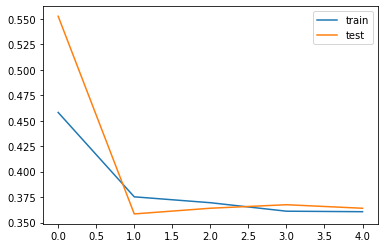

In [29]:
model = train(np.array(et).astype(int), 5, 32)

In [20]:
train_X[2]

NameError: name 'train_X' is not defined

In [36]:
test_input=[[ 0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2]]

In [37]:
test_input_array = np.array(test_input)

In [38]:
test_input_array=test_input_array.astype(int)

In [39]:
test_input_array = test_input_array.reshape((test_input_array.shape[0], 1, test_input_array.shape[1]))

In [40]:
model.predict(test_input_array)

array([[4.6299006e-05, 9.0585113e-01, 5.4006387e-02, 4.0096242e-02]],
      dtype=float32)

In [69]:
len(np.unique(pid))

28028

In [22]:
df = pd.read_csv(r"C:\Users\Shibbs\Desktop\lstm_datasets\lstm_with_seq_100.csv")

In [24]:
df=df[['user_id','product_id','event_type','seq_index']]

In [25]:
df

,user_id,product_id,event_type,seq_index
0,1.515916e+18,4005145,view,0
1,1.515916e+18,4005145,view,1
2,1.515916e+18,4005145,view,2
3,1.515916e+18,4099840,view,3
4,1.515916e+18,3506650,view,4
...,...,...,...,...
596253,1.515920e+18,1716641,view,95
596254,1.515920e+18,4051545,view,96
596255,1.515920e+18,1716639,view,97
596256,1.515920e+18,1682604,view,98
